# Score OCR Results

## Setup

In [1]:
import sys

sys.path.append('..')

In [2]:
import json
import random
import shutil
from os.path import split, splitext
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import tqdm
from PIL import Image

import digi_leap.pylib.ocr_results as results

In [3]:
ROOT_DIR = Path('..')

JUNK_DIR = ROOT_DIR / 'junk'
OUTPUT_DIR = ROOT_DIR / 'data' / 'sernec'
TEXT_DIR = OUTPUT_DIR / 'ensemble_text'
IMAGE_DIR = OUTPUT_DIR / 'ensemble_images'
EXPEDITION = OUTPUT_DIR / 'expedition'
WINNERS = OUTPUT_DIR / 'winners.jsonl'

## OCR Text Files

In [4]:
ALL_FILES = [str(f) for f in TEXT_DIR.glob('*.txt')]

SCORE_FILES = [f for f in ALL_FILES if f.find('Barcode') < 0]

TYPE_FILES = [f for f in ALL_FILES if f.find('Typewritten') >= 0]
HAND_FILES = [f for f in ALL_FILES if f.find('Handwritten') >= 0]
BOTH_FILES = [f for f in ALL_FILES if f.find('Both') >= 0]
BARCODE_FILES = [f for f in ALL_FILES if f.find('Barcode') >= 0]

## Score a File

This function looks for word "hits" in the text file and divides that by the count of all "words" in the. A word is just any string of characters separated by white space.

A "hit" can be one of 3 things:
1. A match in the vocabulary. The vocabulary contains:
    1. The NLTK word corpus
    1. Taxon names for the plant kingdom scraped from the ITIS database
1. A number, which is a string of digits with commas or decimal points like `1,234.5`.
1. A date like `1/23/21` or `1-23-21`.

In [5]:
def score_file(path):
    with open(path) as text_file:
        text = text_file.read()
        words = text.split()
        count = len(words)

    if count == 0:
        return 0.0, 0

    hits = results.hits(text)
    return round(100.0 * hits / count), count

## Show All non-Barcode Scores

In [6]:
x = [score_file(p)[0] for p in SCORE_FILES]

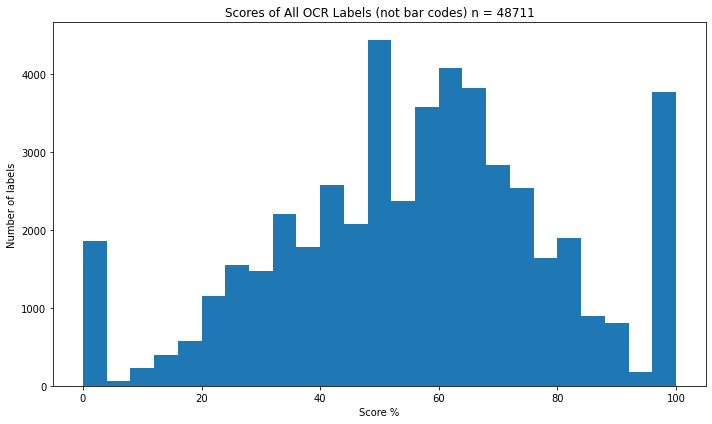

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
n, bins, patches = ax.hist(x, 25)
ax.set_xlabel('Score %')
ax.set_ylabel('Number of labels')
ax.set_title(f'Scores of All OCR Labels (not bar codes) n = {len(x)}')
fig.tight_layout()

fig.savefig(JUNK_DIR / 'ocr_quality_all.png', facecolor='white')
plt.show()

## Show Typewritten Scores

In [8]:
x = [score_file(p)[0] for p in TYPE_FILES]

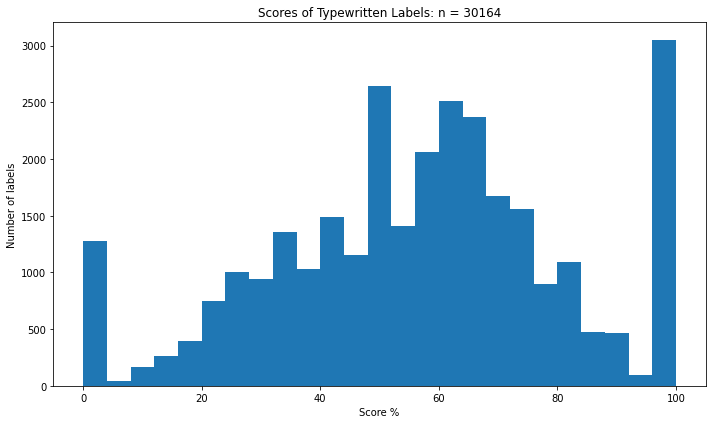

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
n, bins, patches = ax.hist(x, 25)
ax.set_xlabel('Score %')
ax.set_ylabel('Number of labels')
ax.set_title(f'Scores of Typewritten Labels: n = {len(x)}')
fig.tight_layout()
fig.savefig(JUNK_DIR / 'ocr_quality_typewritten.png', facecolor='white')
plt.show()

## Show Mixed (Typewritten & Handwritten) Scores

In [10]:
x = [score_file(p)[0] for p in BOTH_FILES]

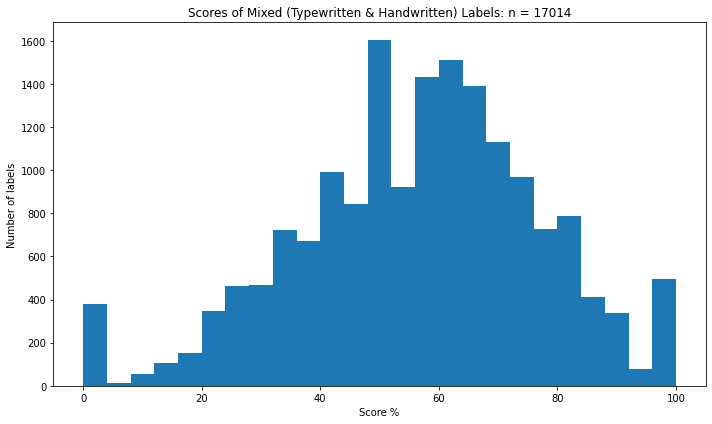

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
n, bins, patches = ax.hist(x, 25)
ax.set_xlabel('Score %')
ax.set_ylabel('Number of labels')
ax.set_title(f'Scores of Mixed (Typewritten & Handwritten) Labels: n = {len(x)}')
fig.tight_layout()
fig.savefig(JUNK_DIR / 'ocr_quality_mixed.png', facecolor='white')
plt.show()

## Show Handwritten Scores

In [12]:
x = [score_file(p)[0] for p in HAND_FILES]

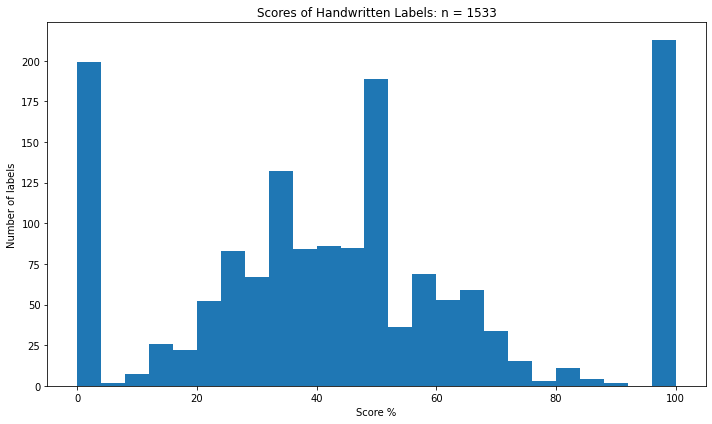

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
n, bins, patches = ax.hist(x, 25)
ax.set_xlabel('Score %')
ax.set_ylabel('Number of labels')
ax.set_title(f'Scores of Handwritten Labels: n = {len(x)}')
fig.tight_layout()
fig.savefig(JUNK_DIR / 'ocr_quality_handwritten.png', facecolor='white')
plt.show()

## Show Bar Code Scores

Many bar codes will have typewritten text on them.

In [14]:
x = [score_file(p)[0] for p in BARCODE_FILES]

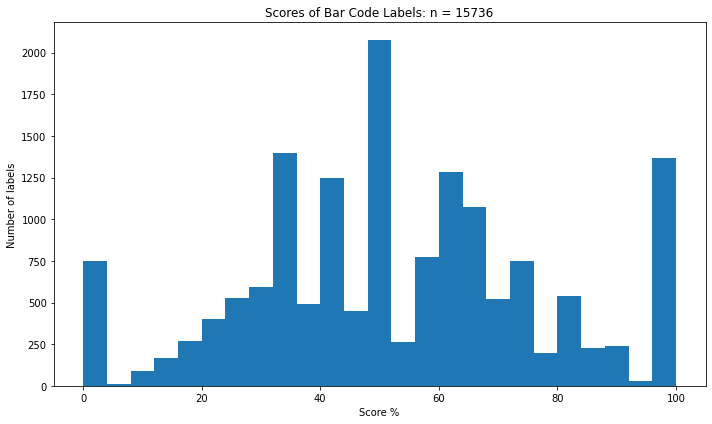

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
n, bins, patches = ax.hist(x, 25)
ax.set_xlabel('Score %')
ax.set_ylabel('Number of labels')
ax.set_title(f'Scores of Bar Code Labels: n = {len(x)}')
fig.tight_layout()
fig.savefig(JUNK_DIR / 'ocr_quality_barcode.png', facecolor='white')
plt.show()

## Sample Results

In [16]:
labels = random.sample(TYPE_FILES, 100)

In [17]:
images = []

for text in labels:
    name = Path(text).stem
    src = IMAGE_DIR / f'{name}.jpg'
    images.append(src)
    # dst = JUNK_DIR / f'{name}.jpg'
    # shutil.copyfile(src, dst)

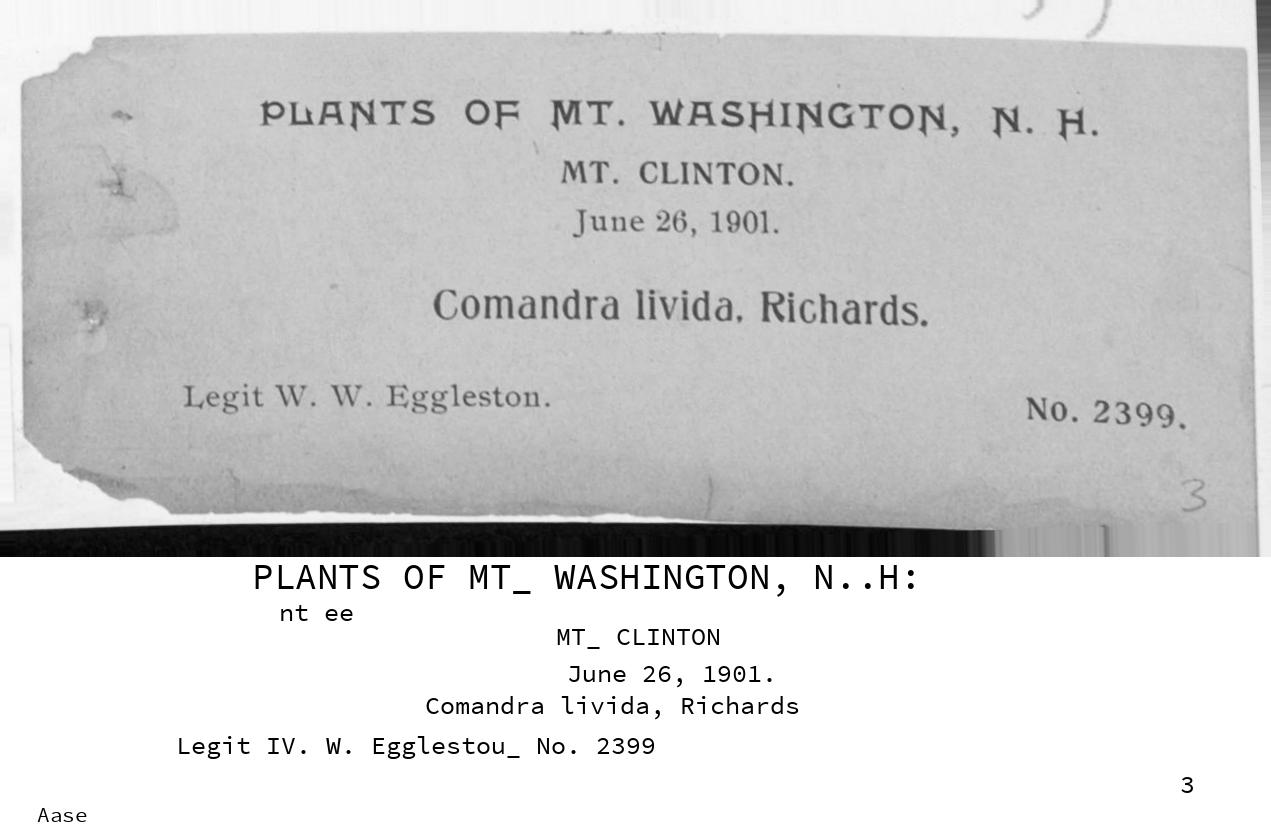

In [18]:
image = Image.open(images[6])
display(image)

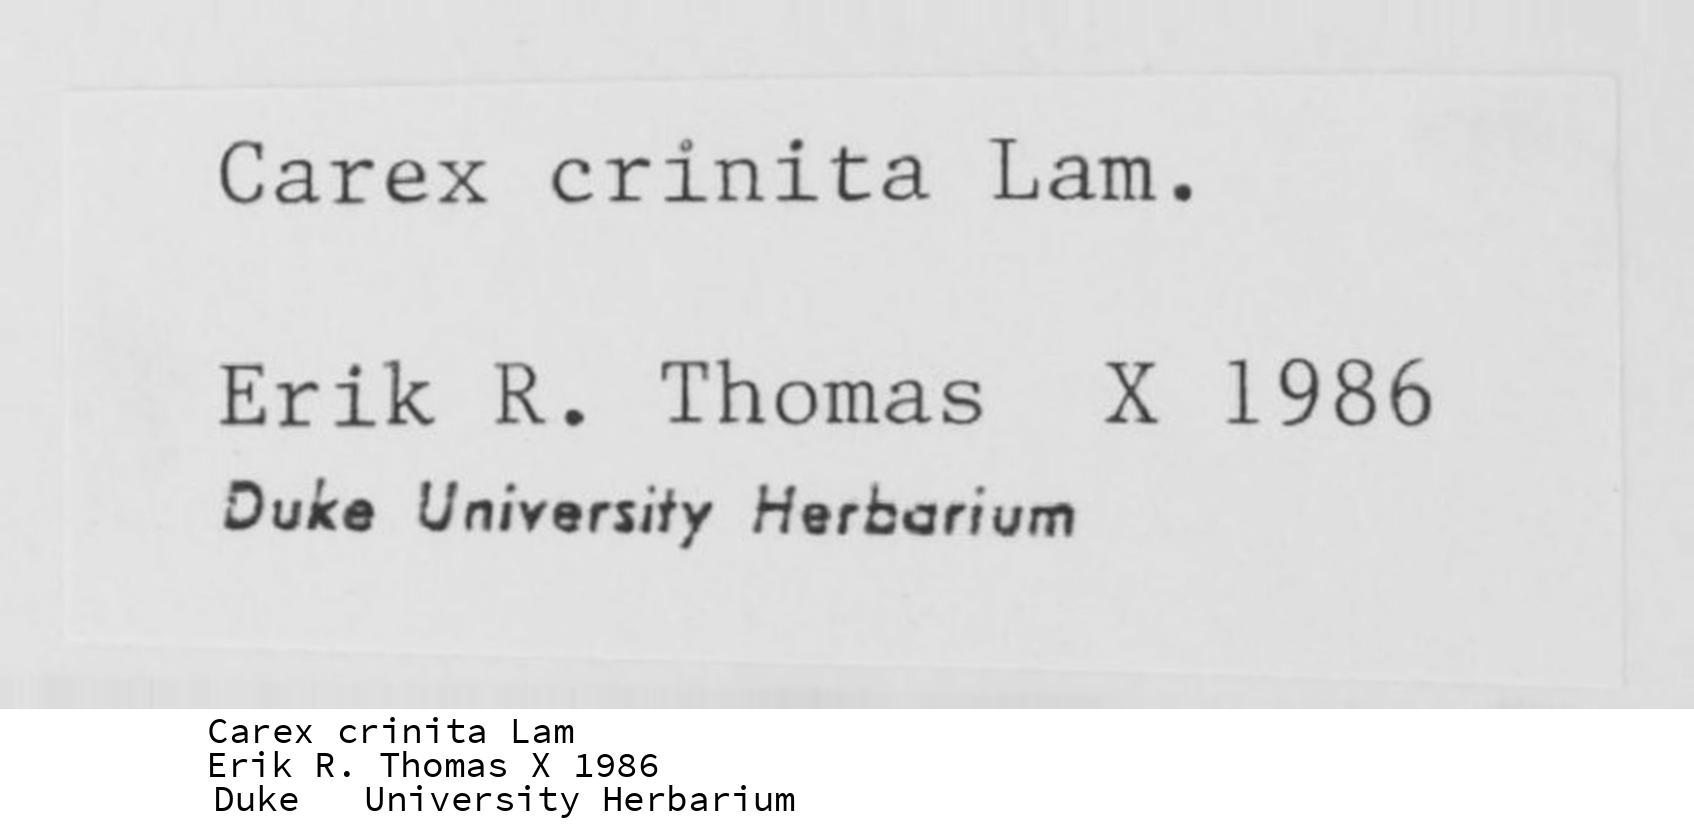

In [19]:
image = Image.open(images[23])
display(image)

## Examine winners' preprocessing type

In [20]:
with open(WINNERS) as jsonl:
    lines = [json.loads(ln) for ln in jsonl.readlines()]
lines[0]

{'text': '“ga SELOO72 74',
 'method': 'score',
 'winners': ['ocr_tesseract_binarize'],
 'score': 0.6666666666666666,
 'stem': '00052cfa-dce8-46d4-8808-78ab84c4f599_0_Barcode'}

### Binarize vs deskew

In [21]:
data = {
    'binarize': 0,
    'deskew': 0,
}

for ln in lines:
    if ln['method'] != 'score' or ln['score'] == 0.0:
        continue
    for win in ln['winners']:
        data['binarize'] += 1 if win.endswith('binarize') else 0
        data['deskew'] += 1 if win.endswith('deskew') else 0

data

{'binarize': 355653, 'deskew': 379672}

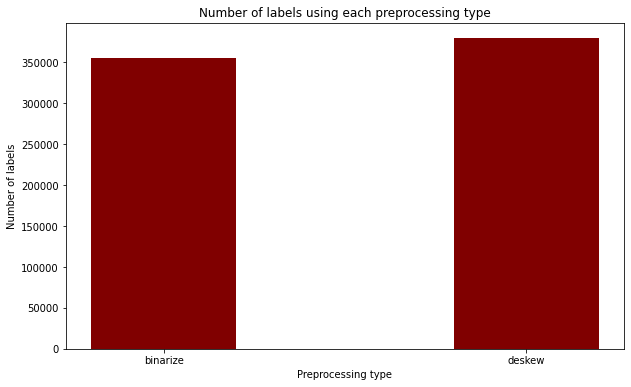

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(list(data.keys()), list(data.values()), color='maroon', width=0.4)
ax.set_xlabel('Preprocessing type')
ax.set_ylabel('Number of labels')
ax.set_title(f'Number of labels using each preprocessing type')
plt.show()

### Binarize vs deskew for typewritten labels

In [23]:
data = {
    'binarize': 0,
    'deskew': 0,
}

for ln in lines:
    if ln['method'] != 'score' or ln['score'] == 0.0:
        continue
    if not ln['stem'].endswith('Typewritten'):
        continue
    for win in ln['winners']:
        data['binarize'] += 1 if win.endswith('binarize') else 0
        data['deskew'] += 1 if win.endswith('deskew') else 0

data

{'binarize': 192947, 'deskew': 198845}

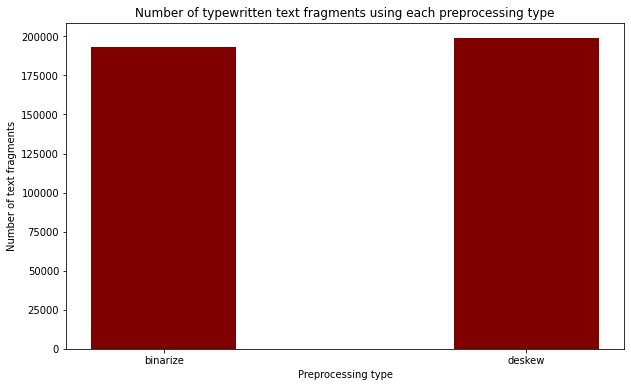

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(list(data.keys()), list(data.values()), color='maroon', width=0.4)
ax.set_xlabel('Preprocessing type')
ax.set_ylabel('Number of text fragments')
ax.set_title(f'Number of typewritten text fragments using each preprocessing type')
plt.show()

### Binarize vs deskew for expedition labels

In [25]:
data = {
    'binarize': 0,
    'deskew': 0,
}

expedtion = {p.stem for p in EXPEDITION.glob('*.jpg')}

for ln in lines:
    if ln['method'] != 'score' or ln['score'] == 0.0:
        continue
    if not ln['stem']in expedtion:
        continue
    for win in ln['winners']:
        data['binarize'] += 1 if win.endswith('binarize') else 0
        data['deskew'] += 1 if win.endswith('deskew') else 0

data

{'binarize': 63635, 'deskew': 59937}

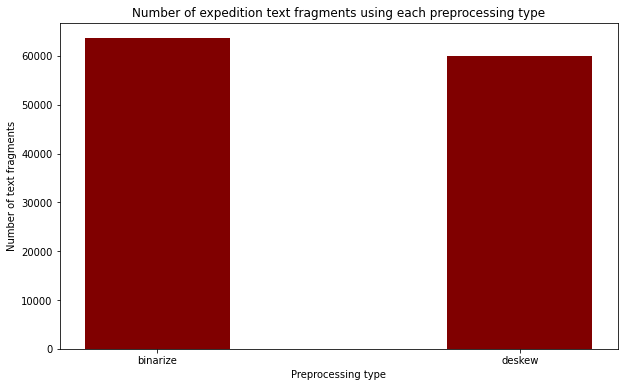

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(list(data.keys()), list(data.values()), color='maroon', width=0.4)
ax.set_xlabel('Preprocessing type')
ax.set_ylabel('Number of text fragments')
ax.set_title(f'Number of expedition text fragments using each preprocessing type')
plt.show()

## Examine winners' OCR engine

### EasyOCR vs Tesseract

In [27]:
data = {
    'easyocr': 0,
    'tesseract': 0,
}

for ln in lines:
    if ln['method'] != 'score' or ln['score'] == 0.0:
        continue
    for win in ln['winners']:
        data['easyocr'] += 1 if win.find('easyocr') > -1 else 0
        data['tesseract'] += 1 if win.find('tesseract') > -1 else 0

data

{'easyocr': 396645, 'tesseract': 338680}

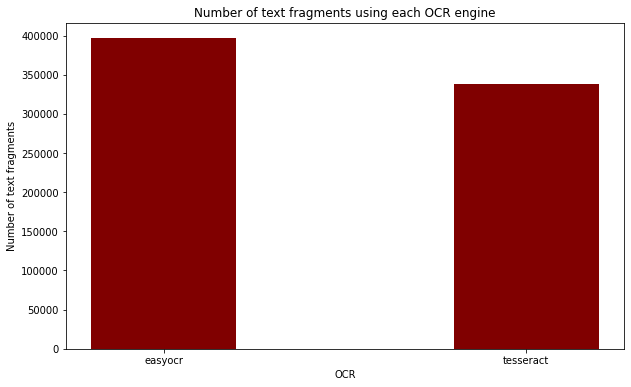

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(list(data.keys()), list(data.values()), color='maroon', width=0.4)
ax.set_xlabel('OCR')
ax.set_ylabel('Number of text fragments')
ax.set_title(f'Number of text fragments using each OCR engine')
plt.show()

### EasyOCR vs Tesseract for typewritten labels

In [29]:
data = {
    'easyocr': 0,
    'tesseract': 0,
}

for ln in lines:
    if ln['method'] != 'score' or ln['score'] == 0.0:
        continue
    if not ln['stem'].endswith('Typewritten'):
        continue
    for win in ln['winners']:
        data['easyocr'] += 1 if win.find('easyocr') > -1 else 0
        data['tesseract'] += 1 if win.find('tesseract') > -1 else 0

data

{'easyocr': 200542, 'tesseract': 191250}

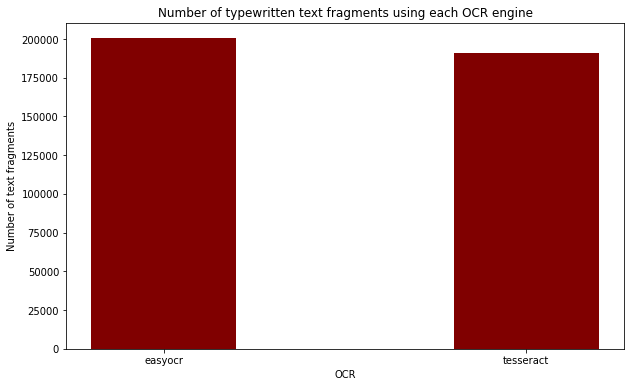

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(list(data.keys()), list(data.values()), color='maroon', width=0.4)
ax.set_xlabel('OCR')
ax.set_ylabel('Number of text fragments')
ax.set_title(f'Number of typewritten text fragments using each OCR engine')
plt.show()

### EasyOCR vs Tesseract for expedition labels

In [31]:
data = {
    'easyocr': 0,
    'tesseract': 0,
}

for ln in lines:
    if ln['method'] != 'score' or ln['score'] == 0.0:
        continue
    if not ln['stem']in expedtion:
        continue
    for win in ln['winners']:
        data['easyocr'] += 1 if win.find('easyocr') > -1 else 0
        data['tesseract'] += 1 if win.find('tesseract') > -1 else 0

data

{'easyocr': 52894, 'tesseract': 70678}

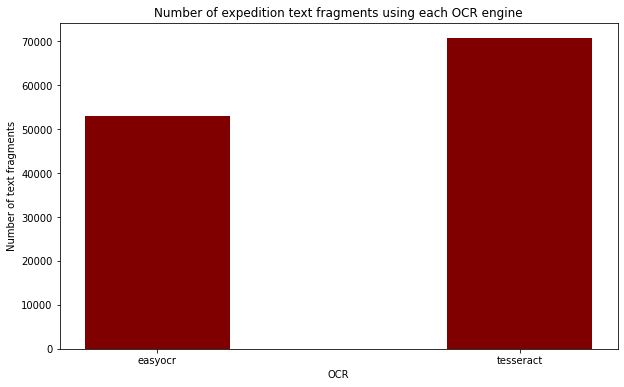

In [32]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(list(data.keys()), list(data.values()), color='maroon', width=0.4)
ax.set_xlabel('OCR')
ax.set_ylabel('Number of text fragments')
ax.set_title(f'Number of expedition text fragments using each OCR engine')
plt.show()